In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor as RFR
from IPython.core.debugger import Tracer
import scipy.sparse as sp
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Predicción de los parámetros más importantes

In [31]:
import warnings
warnings.filterwarnings('ignore')

Lo primero que hacemos es leer los archivos y sacar longitudes de datos.

In [32]:
datah= pd.read_csv('highp_finalresults.csv')
datal= pd.read_csv('lowp_finalresults.csv')
datah['rplanet(i)/radtie'][26720]=datah['rplanet(i)/radtie'][26721]
datal['rplanet(i)/radtie'] = datal['rplanet(i)/radtie'].str.replace(',','.').astype(np.float64)
datal['rplanet(i)/radtie'][21123]=datah['rplanet(i)/radtie'][21124]
datal['rplanet(i)/radtie'][28194]=datah['rplanet(i)/radtie'][28195]

len_h=len(datah['it'])
len_l=len(datal['it'])

Ahora, para cada planeta se va a agregar cada uno de los parámetros que quiero predecir: número de planetas, masa total de planetas y eficiencia de masa.

In [33]:
numplan = np.array([])
masast = np.array([])
cont=1
masas = datah['emepla(i)/emet'][0]
k=0
for i in range(max(datah['ident'])+1):
    for j in range (len_h):
        k+=1
        if k==len_h:
            break
            
        if(int(datah['ident'][k]) != i):
            k-=1
            break
        cont+=1
        masas += datah['emepla(i)/emet'][k]
        
    numplan = np.append(numplan,cont)
    masast = np.append(masast,masas)
    cont = 0
    masas = 0
    
bignumpla = np.zeros(len_h)
bigmasas = np.zeros(len_h)
k = 0
for i in range(max(datah['ident'])+1):
    for j in range(int(numplan[i])):
        bignumpla[k] = numplan[i]
        bigmasas[k] = masast[i]
        k += 1
        
datah['numpla']=pd.Series(bignumpla,index = datah.index)
datah['masastot']=pd.Series(bigmasas,index = datah.index)
datah['efic']=pd.Series(datah['masastot']/datah['emed'],index = datah.index)

In [34]:
numplan = np.array([])
masast = np.array([])
cont=1
masas = datal['emepla(i)/emet'][0]
k=0
for i in range(max(datal['ident'])+1):
    for j in range (len_l):
        k+=1
        if k==len_l:
            break
            
        if(int(datal['ident'][k]) != i):
            k-=1
            break
        cont+=1
        masas += datal['emepla(i)/emet'][k]
        
    numplan = np.append(numplan,cont)
    masast = np.append(masast,masas)
    cont = 0
    masas = 0
    
bignumpla = np.zeros(len_l)
bigmasas = np.zeros(len_l)
k = 0
for i in range(max(datal['ident'])+1):
    for j in range(int(numplan[i])):
        bignumpla[k] = numplan[i]
        bigmasas[k] = masast[i]
        k += 1
        
datal['numpla']=pd.Series(bignumpla,index = datal.index)
datal['masastot']=pd.Series(bigmasas,index = datal.index)
datal['efic']=pd.Series(datal['masastot']/datal['emed'],index = datal.index)

## Análisis para los datos 'highp'

En este punto ya están listos los datos para implementar el algoritmo de Lasso para precir cada uno de los parámetros agregados anteriormente. Para empezar, mirando los datos, encontramos 5 variables que no cambiaban de planeta en planeta, por lo que no se tuvieron en cuenta para el análisis. Además, se tranformaron los datos de forma tal que la media fuera 0 y la desviación estándar sea 1. Esto se hizo para que el modelo no dependiera de las unidades de los parámetros.

In [35]:
Y1 = datah['numpla']
Y2 = datah['masastot']
Y3 = datah['efic']
X = datah[['ident', 'it', 'a(i)', 'emegas(i)', 'emepla(i)/emet', 'rplanet(i)/radtie'
           , 'emestar', 'rc', 'qest', 'sigmag_0', 'emed', 'emetal', 'taugas']]
X_train, X_test, Y1_train, Y1_test = train_test_split(X, Y1, random_state=1)
X_train, X_test, Y2_train, Y2_test = train_test_split(X, Y2, random_state=1)
X_train, X_test, Y3_train, Y3_test = train_test_split(X, Y3, random_state=1)

In [36]:
train_scaler = preprocessing.StandardScaler().fit(X_train)
test_scaler = preprocessing.StandardScaler().fit(X_test)
X_traine = train_scaler.transform(X_train)
X_teste = test_scaler.transform(X_test)

In [37]:
print(np.mean(X_traine))
print(np.std(X_traine,axis=0))

1.1217418112349207e-16
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Ahora, para definir qué parámetros son más importantes se pretende hacer gráficas del valor de los parámetros en función de la constante $\alpha$, y los que caigan a 0 primero son los que menos importancia tienen en el modelo.

In [38]:
alphas = np.linspace(0.01, 1.3, 80)
coefs1 = np.array([])
temp = np.array([])
scores1 = []
scores_std1 = []
for i in range(np.size(alphas)):
    clf1 = linear_model.Lasso(alpha=alphas[i])
    clf1.fit(X_traine, Y1_train)
    this_scores = cross_val_score(clf1, X_teste, Y1_test, cv=5)
    scores1.append(np.mean(this_scores))
    scores_std1.append(np.std(this_scores))
    for j in range(np.size(clf1.coef_)):
        temp = np.append(temp, clf1.coef_[j])
    coefs1 = np.append(coefs1, temp)
    temp = np.array([])
std_err1 = np.array(scores_std1)/np.sqrt(5)

In [39]:
alphas2 = np.linspace(0.01, 300,80)
coefs2 = np.array([])
temp = np.array([])
scores2 = []
scores_std2 = []
for i in range(np.size(alphas2)):
    clf2 = linear_model.Lasso(alpha=alphas2[i])
    clf2.fit(X_traine, Y2_train)
    this_scores = cross_val_score(clf2, X_teste, Y2_test, cv=5)
    scores2.append(np.mean(this_scores))
    scores_std2.append(np.std(this_scores))
    for j in range(np.size(clf2.coef_)):
        temp = np.append(temp, clf2.coef_[j])
    coefs2 = np.append(coefs2, temp)
    temp = np.array([])
    
std_err2 = np.array(scores_std1)/np.sqrt(5)

In [40]:
alphas3 = np.linspace(0.01, 5000,500)
coefs3 = np.array([])
temp = np.array([])
scores3 = []
scores_std3 = []
for i in range(np.size(alphas3)):
    clf3 = linear_model.Lasso(alpha=alphas3[i])
    clf3.fit(X_traine, Y3_train)
    this_scores = cross_val_score(clf3, X_teste, Y3_test, cv=5)
    scores3.append(np.mean(this_scores))
    scores_std3.append(np.std(this_scores))
    for j in range(np.size(clf3.coef_)):
        temp = np.append(temp, clf3.coef_[j])
    coefs3 = np.append(coefs3, temp)
    temp = np.array([])
    
std_err3 = np.array(scores_std3)/np.sqrt(5)

De aquí en adelante se presentan los resultados para cada una de las variables a predecir.

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, **kwargs)>

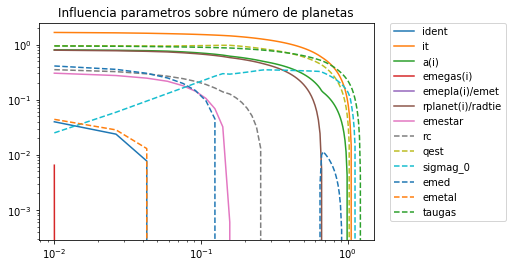

In [41]:
# Número de planetas
coefs1 = coefs1.reshape(len(alphas), 13)
nombres = ['ident', 'it', 'a(i)', 'emegas(i)', 'emepla(i)/emet', 'rplanet(i)/radtie'
           , 'emestar', 'rc', 'qest', 'sigmag_0', 'emed', 'emetal', 'taugas']
for i in range(0,np.size(coefs1[0])):
    if(i<7):
        plt.plot(alphas, abs(coefs1[:,i]),label=nombres[i])
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(0,1.5)
    else:
        plt.plot(alphas, abs(coefs1[:,i]),label=nombres[i],ls='--')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(0,1.5)
        
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Influencia parametros sobre número de planetas")
plt.xlabel

Según la clasificación realizada con Lasso, los parámetros que convergen al final a cero son los que mayor importancia tienen. Los encontrados fueron, en orden de importancia:
- gas dissipation timescale (yr)
- maximum dust surface density (g/cm^3) 	
- iteration index
- Toomre Q at min radius
- planet semi-major axis (AU)
- disk mass (M_sun)
- planet solid radius
- disk outer cutoff radius (AU)
- stellar mass (g)
- metallicity wrt solar
- unique system identifier



Text(0.5, 1.0, 'Cross val Scores for number of planets')

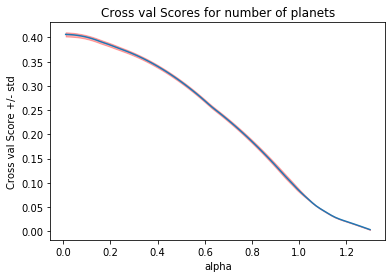

In [42]:
plt.plot(alphas,scores1)
plt.fill_between(alphas, scores1 + std_err1, scores1 - std_err1, alpha=0.3
                 , color='red')
plt.ylabel('Cross val Score +/- std')
plt.xlabel('alpha')
plt.title('Cross val Scores for number of planets')

La gráfica de arriba muestra el rango de valores de los 'score' en función de la constante $\alpha$.

Text(0.5, 1.0, 'Influencia parametros sobre masa total de planetas')

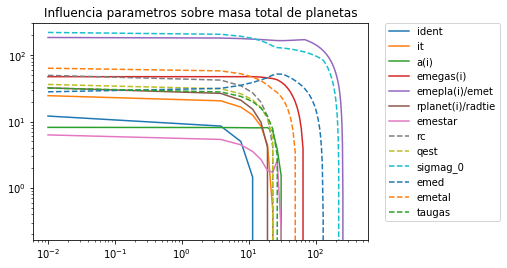

In [43]:
#Masas
coefs2 = coefs2.reshape(len(alphas2), 13)
nombres = ['ident', 'it', 'a(i)', 'emegas(i)', 'emepla(i)/emet', 'rplanet(i)/radtie'
           , 'emestar', 'rc', 'qest', 'sigmag_0', 'emed', 'emetal', 'taugas']
for i in range(0,np.size(coefs2[0])):
    if(i<7):
        plt.plot(alphas2, abs(coefs2[:,i]),label=nombres[i])
        plt.xscale('log')
        plt.yscale('log')

    else:
        plt.plot(alphas2, abs(coefs2[:,i]),label=nombres[i],ls='--')
        plt.xscale('log')
        plt.yscale('log')

plt.xlim(0,600)        
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Influencia parametros sobre masa total de planetas")

Según la clasificación realizada con Lasso, los parametros que convergen al final a cero son los que mayor importancia tienen. Los encontrados fueron, en orden de importancia:
- planet solid mass (M_earth) 
- maximum dust surface density (g/cm^3)
- disk mass (M_sun)
- planet gas mass (M_earth)
- metallicity wrt solar
- planet semi-major axis (AU)
- stellar mass (g)
- gas dissipation timescale (yr)
- Toomre Q at min radius
- iteration index
- disk outer cutoff radius (AU)
- planet solid radius
- unique system identifier


Text(0.5, 1.0, 'Cross val Scores for total planet masses')

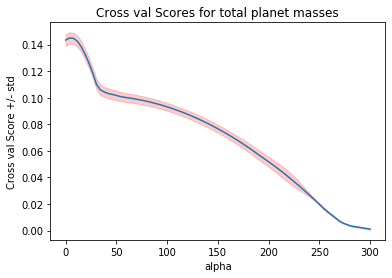

In [44]:
plt.plot(alphas2,scores2)
plt.fill_between(alphas2, scores2 + std_err2, scores2 - std_err2, alpha=0.2, color = 'red')
plt.ylabel('Cross val Score +/- std')
plt.xlabel('alpha')

plt.title('Cross val Scores for total planet masses')

La gráfica de arriba muestra el rango de valores de los 'score' en función de la constante $\alpha$.

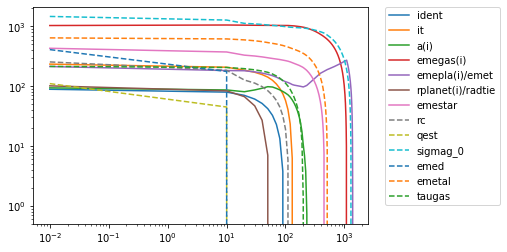

In [45]:
coefs3 = coefs3.reshape(len(alphas3), 13)
nombres = ['ident', 'it', 'a(i)', 'emegas(i)', 'emepla(i)/emet', 'rplanet(i)/radtie'
           , 'emestar', 'rc', 'qest', 'sigmag_0', 'emed', 'emetal', 'taugas']
for i in range(0,np.size(coefs3[0])):
    if(i<7):
        plt.plot(alphas3, abs(coefs3[:,i]),label=nombres[i])
        plt.xscale('log')
        plt.yscale('log')

    else:
        plt.plot(alphas3, abs(coefs3[:,i]),label=nombres[i],ls='--')
        plt.xscale('log')
        plt.yscale('log')

    plt.xlim(0,2500)  
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

De igual forma que en los dos casos anteriores, los parámetros que convergen al final a cero son los que mayor importancia tienen.

Text(0.5, 1.0, 'Cross val Scores for mass efficiency')

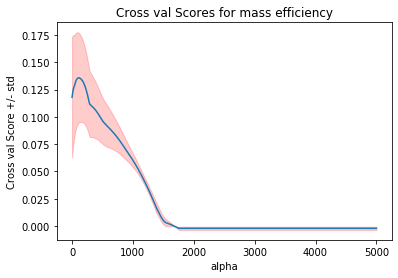

In [46]:
plt.plot(alphas3,scores3)
plt.fill_between(alphas3, scores3 + std_err3, scores3 - std_err3, alpha=0.2
                 , color = 'red')
plt.ylabel('Cross val Score +/- std')
plt.xlabel('alpha')

plt.title('Cross val Scores for mass efficiency')

La gráfica de arriba muestra el rango de valores de los 'score' en función de la constante $\alpha$.

## Análisis para los datos 'lowp'

Este análisis es el mismo que para los datos 'highp':

In [47]:
Y4 = datal['numpla']
Y5 = datal['masastot']
Y6 = datal['efic']
X2 = datal[['ident', 'it', 'a(i)', 'emegas(i)', 'emepla(i)/emet', 'rplanet(i)/radtie'
            , 'emestar', 'rc', 'qest', 'sigmag_0', 'emed', 'emetal', 'taugas']]
X2_train, X2_test, Y4_train, Y4_test = train_test_split(X2, Y4, random_state=1)
X2_train, X2_test, Y5_train, Y5_test = train_test_split(X2, Y5, random_state=1)
X2_train, X2_test, Y6_train, Y6_test = train_test_split(X2, Y6, random_state=1)

In [48]:
train_scaler2 = preprocessing.StandardScaler().fit(X2)
test_scaler2 = preprocessing.StandardScaler().fit(X2_test)
X2_traine = train_scaler2.transform(X2_train)
X2_teste = test_scaler2.transform(X2_test)

In [49]:
print(np.mean(X2_traine))
print(np.std(X2_traine,axis=0))

-0.00020655410970417415
[0.99882026 1.00382208 0.99894545 0.95213235 0.95169358 1.00205916
 0.99645613 1.00072476 1.00180105 0.99756736 0.99663468 1.0005573
 0.99720483]


In [50]:
alphas = np.linspace(0.01, 1.3, 80)
coefs1 = np.array([])
temp = np.array([])
scores1 = []
scores_std1 = []
for i in range(np.size(alphas)):
    clf1 = linear_model.Lasso(alpha=alphas[i])
    clf1.fit(X2_traine, Y4_train)
    this_scores = cross_val_score(clf1, X2_teste, Y4_test, cv=5)
    scores1.append(np.mean(this_scores))
    scores_std1.append(np.std(this_scores))
    for j in range(np.size(clf1.coef_)):
        temp = np.append(temp, clf1.coef_[j])
    coefs1 = np.append(coefs1, temp)
    temp = np.array([])
std_err1 = np.array(scores_std1)/np.sqrt(5)

In [51]:
alphas2 = np.linspace(0.01, 300,80)
coefs2 = np.array([])
temp = np.array([])
scores2 = []
scores_std2 = []
for i in range(np.size(alphas2)):
    clf2 = linear_model.Lasso(alpha=alphas2[i])
    clf2.fit(X2_traine, Y5_train)
    this_scores = cross_val_score(clf2, X2_teste, Y5_test, cv=5)
    scores2.append(np.mean(this_scores))
    scores_std2.append(np.std(this_scores))
    for j in range(np.size(clf2.coef_)):
        temp = np.append(temp, clf2.coef_[j])
    coefs2 = np.append(coefs2, temp)
    temp = np.array([])
    
std_err2 = np.array(scores_std1)/np.sqrt(5)

In [52]:
alphas3 = np.linspace(0.01, 5000,500)
coefs3 = np.array([])
temp = np.array([])
scores3 = []
scores_std3 = []
for i in range(np.size(alphas3)):
    clf3 = linear_model.Lasso(alpha=alphas3[i])
    clf3.fit(X2_traine, Y6_train)
    this_scores = cross_val_score(clf3, X2_teste, Y6_test, cv=5)
    scores3.append(np.mean(this_scores))
    scores_std3.append(np.std(this_scores))
    for j in range(np.size(clf3.coef_)):
        temp = np.append(temp, clf3.coef_[j])
    coefs3 = np.append(coefs3, temp)
    temp = np.array([])
    
std_err3 = np.array(scores_std3)/np.sqrt(5)

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, **kwargs)>

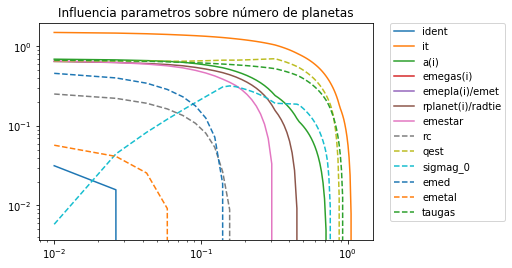

In [53]:
# Número de planetas
coefs1 = coefs1.reshape(len(alphas), 13)
nombres = ['ident', 'it', 'a(i)', 'emegas(i)', 'emepla(i)/emet', 'rplanet(i)/radtie'
           , 'emestar', 'rc', 'qest', 'sigmag_0', 'emed', 'emetal', 'taugas']
for i in range(0,np.size(coefs1[0])):
    if(i<7):
        plt.plot(alphas, abs(coefs1[:,i]),label=nombres[i])
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(0,1.5)
    else:
        plt.plot(alphas, abs(coefs1[:,i]),label=nombres[i],ls='--')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(0,1.5)
        
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Influencia parametros sobre número de planetas")
plt.xlabel

De igual forma que en los dos casos anteriores, los parámetros que convergen al final a cero son los que mayor importancia tienen.

Text(0.5, 1.0, 'Cross val Scores for number of planets')

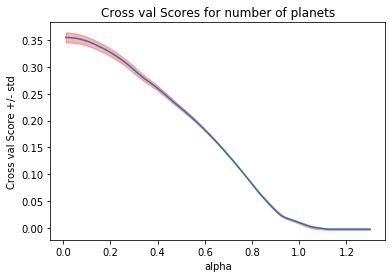

In [54]:
plt.plot(alphas,scores1)
plt.fill_between(alphas, scores1 + std_err1, scores1 - std_err1, alpha=0.3, color='red')
plt.ylabel('Cross val Score +/- std')
plt.xlabel('alpha')
plt.title('Cross val Scores for number of planets')

Text(0.5, 1.0, 'Influencia parametros sobre masa total de planetas')

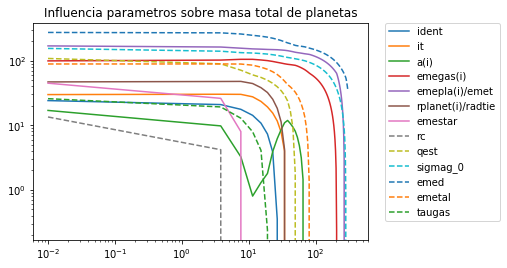

In [55]:
#Masas
coefs2 = coefs2.reshape(len(alphas2), 13)
nombres = ['ident', 'it', 'a(i)', 'emegas(i)', 'emepla(i)/emet', 'rplanet(i)/radtie'
           , 'emestar', 'rc', 'qest', 'sigmag_0', 'emed', 'emetal', 'taugas']
for i in range(0,np.size(coefs2[0])):
    if(i<7):
        plt.plot(alphas2, abs(coefs2[:,i]),label=nombres[i])
        plt.xscale('log')
        plt.yscale('log')

    else:
        plt.plot(alphas2, abs(coefs2[:,i]),label=nombres[i],ls='--')
        plt.xscale('log')
        plt.yscale('log')

plt.xlim(0,600)        
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Influencia parametros sobre masa total de planetas")

De igual forma que en los dos casos anteriores, los parámetros que convergen al final a cero son los que mayor importancia tienen.

Text(0.5, 1.0, 'Cross val Scores for total planet masses')

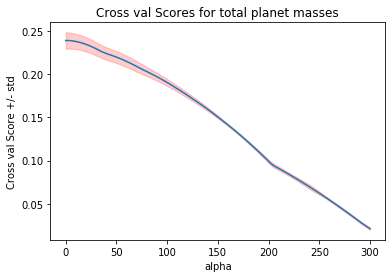

In [56]:
plt.plot(alphas2,scores2)
plt.fill_between(alphas2, scores2 + std_err2, scores2 - std_err2, alpha=0.2
                 , color = 'red')
plt.ylabel('Cross val Score +/- std')
plt.xlabel('alpha')

plt.title('Cross val Scores for total planet masses')

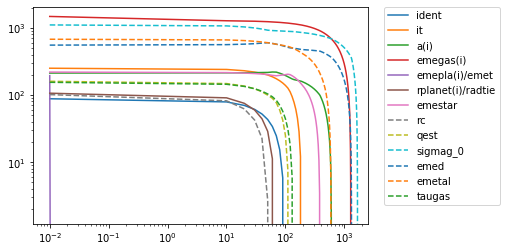

In [57]:
coefs3 = coefs3.reshape(len(alphas3), 13)
nombres = ['ident', 'it', 'a(i)', 'emegas(i)', 'emepla(i)/emet', 'rplanet(i)/radtie'
           , 'emestar', 'rc', 'qest', 'sigmag_0', 'emed', 'emetal', 'taugas']
for i in range(0,np.size(coefs3[0])):
    if(i<7):
        plt.plot(alphas3, abs(coefs3[:,i]),label=nombres[i])
        plt.xscale('log')
        plt.yscale('log')

    else:
        plt.plot(alphas3, abs(coefs3[:,i]),label=nombres[i],ls='--')
        plt.xscale('log')
        plt.yscale('log')

    plt.xlim(0,2500)  
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

De igual forma que en los dos casos anteriores, los parámetros que convergen al final a cero son los que mayor importancia tienen.

Text(0.5, 1.0, 'Cross val Scores for mass efficiency')

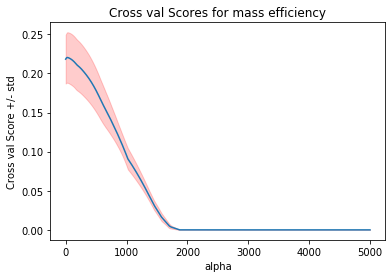

In [58]:
plt.plot(alphas3,scores3)
plt.fill_between(alphas3, scores3 + std_err3, scores3 - std_err3, alpha=0.2
                 , color = 'red')
plt.ylabel('Cross val Score +/- std')
plt.xlabel('alpha')

plt.title('Cross val Scores for mass efficiency')

Podemos concluir entonces que, aplicando el algoritmo de Lasso para un modelo lineal, se puede obtener qué parámetros son más importantes que otros para la predicción de otro parámetro del sistema. De todos los casos analizados podemos ver que parámetros como 'ident' e 'it' no tienen importancia, como era esperado.